<a href="https://colab.research.google.com/github/hungpx2008/AIO-Exercise/blob/Feature%2FExercise-activate-funtion/Project_image_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install chromadb
!pip install open-clip-torch

In [ ]:
!gdown --id 1--6fe48D9ydnTpLV1GKKqJ0pqpOXB3z_

In [ ]:
!unzip Clean_Dataset

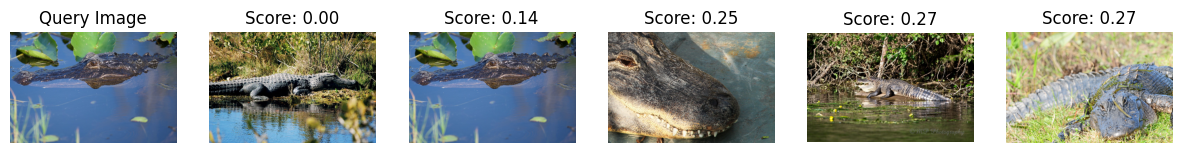

In [19]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

# Đường dẫn tới dataset
ROOT = 'Dataset/animal'
CLASS_NAME = sorted(list(os.listdir(f'{ROOT}')))

def read_image_from_path(path, size):
    im = Image.open(path).convert('RGB').resize(size)
    return np.array(im)

def folder_to_images(folder, size):
    list_dir = [folder + '/' + name for name in os.listdir(folder)]
    images_np = np.zeros(shape=(len(list_dir), *size, 3))
    images_path = []
    for i, path in enumerate(list_dir):
        images_np[i] = read_image_from_path(path, size)
        images_path.append(path)
    images_path = np.array(images_path)
    return images_np, images_path

def absolute_difference(query, data):
    axis_batch_size = tuple(range(1, len(data.shape)))
    return np.sum(np.abs(data - query), axis=axis_batch_size)

def mean_square_difference(query, data):
    axis_batch_size = tuple(range(1, len(data.shape)))
    return np.mean((data - query)**2, axis=axis_batch_size)

def cosine_similarity(query, data):
    axis_batch_size = tuple(range(1, len(data.shape)))
    query_norm = np.sqrt(np.sum(query**2))
    data_norm = np.sqrt(np.sum(data**2, axis=axis_batch_size))
    return np.sum(data * query, axis=axis_batch_size) / (query_norm*data_norm + np.finfo(float).eps)

def correlation_coefficient(query, data):
    axis_batch_size = tuple(range(1, len(data.shape)))
    query_mean = query - np.mean(query)
    data_mean = data - np.mean(data, axis=axis_batch_size, keepdims=True)
    query_norm = np.sqrt(np.sum(query_mean**2))
    data_norm = np.sqrt(np.sum(data_mean**2, axis=axis_batch_size))
    return np.sum(data_mean * query_mean, axis=axis_batch_size) / (query_norm*data_norm + np.finfo(float).eps)

def get_l1_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + '/' + folder
            images_np, images_path = folder_to_images(path, size)
            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)
            rates = absolute_difference(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

def get_l2_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + '/' + folder
            images_np, images_path = folder_to_images(path, size)
            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)
            rates = mean_square_difference(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

def get_cosine_similarity_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + '/' + folder
            images_np, images_path = folder_to_images(path, size)
            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)
            rates = cosine_similarity(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

def get_correlation_coefficient_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + '/' + folder
            images_np, images_path = folder_to_images(path, size)
            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)
            rates = correlation_coefficient(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

embedding_function = OpenCLIPEmbeddingFunction()

def get_single_image_embedding(image):
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    embedding = embedding_function._encode_image(image=image)
    if isinstance(embedding, np.ndarray):
        return embedding.tolist()
    return embedding

def get_files_path(path):
    files_path = []
    for label in CLASS_NAME:
        label_path = path + "/" + label
        filenames = os.listdir(label_path)
        for filename in filenames:
            filepath = label_path + '/' + filename
            files_path.append(filepath)
    return files_path

def add_embedding(collection, files_path):
    ids = []
    embeddings = []
    for id_filepath, filepath in enumerate(files_path):
        ids.append(f'id_{id_filepath}')
        image = read_image_from_path(filepath, (224, 224))
        embedding = get_single_image_embedding(image=image)
        embeddings.append(embedding)
    collection.add(embeddings=embeddings, ids=ids)

# Create a Chroma Client
chroma_client = chromadb.Client()

# Create a collection for L2
l2_collection = chroma_client.get_or_create_collection(name="l2_collection", metadata={"HNSW_SPACE": "l2"})

# Add embeddings to collection
data_path = f'{ROOT}'
files_path = get_files_path(path=data_path)
add_embedding(collection=l2_collection, files_path=files_path)

def search(image_path, collection, n_results):
    query_image = read_image_from_path(image_path, (224, 224))
    query_embedding = get_single_image_embedding(query_image)
    results = collection.query(query_embeddings=[query_embedding], n_results=n_results)
    return results

def plot_results(query_path, ls_path_score, reverse=False):
    ls_path_score.sort(key=lambda x: x[1], reverse=reverse)
    query_image = Image.open(query_path)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 6, 1)
    plt.imshow(query_image)
    plt.axis('off')
    plt.title('Query Image')
    for i in range(5):
        image_path, score = ls_path_score[i]
        image = Image.open(image_path)
        plt.subplot(1, 6, i+2)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Score: {score:.2f}')
    plt.show()

# Example search and plot
test_path = f'{ROOT}'
test_files_path = get_files_path(path=test_path)
test_image_path = test_files_path[1]
l2_results = search(image_path=test_image_path, collection=l2_collection, n_results=5)

# Adjust `plot_results` call to use the correct input
plot_results(query_path=test_image_path, ls_path_score=[(files_path[i], l2_results['distances'][0][i]) for i in range(5)], reverse=False)

# Create a collection for Cosine Similarity
cosine_collection = chroma_client.get_or_create_collection(name="Cosine_collection", metadata={"HNSW_SPACE": "cosine"})
add_embedding(collection=cosine_collection, files_path=files_path)
